##### **Imports**

In [374]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC

## Data Collection & Cleaning

In [336]:
data = pd.read_csv('/Users/sohamkakra/Desktop/Dissertation Project/B.Sc.-Dissertation-Project/Datasets/Asteroid Dataset 2.csv')
data.dropna()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3110 entries, 0 to 3109
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       3110 non-null   object 
 1   neo             3110 non-null   object 
 2   pha             3110 non-null   object 
 3   sats            3110 non-null   int64  
 4   H               3110 non-null   float64
 5   G               12 non-null     float64
 6   diameter        765 non-null    float64
 7   extent          10 non-null     object 
 8   albedo          732 non-null    float64
 9   rot_per         1103 non-null   float64
 10  GM              4 non-null      float64
 11  BV              37 non-null     float64
 12  UB              37 non-null     float64
 13  spec_B          263 non-null    object 
 14  spec_T          35 non-null     object 
 15  orbit_id        3110 non-null   object 
 16  epoch           3110 non-null   float64
 17  equinox         3110 non-null   o

,full_name,neo,pha,sats,H,G,diameter,extent,albedo,rot_per,...,moid_jup,t_jup,class,producer,data_arc,first_obs,last_obs,n_obs_used,condition_code,rms
0,719 Albert (A911 TB),Y,N,0,15.59,NaN,NaN,NaN,NaN,5.8010,...,1.42,3.14,AMO,Otto Matic,40483,04/10/11,05/08/22,2035,0,0.41003
1,887 Alinda (A918 AA),Y,N,0,13.83,-0.12,4.200,NaN,0.310,28.4100,...,1.32,3.22,AMO,Otto Matic,38167,03/02/18,03/08/22,2676,0,0.40156
2,1036 Ganymed (A924 UB),Y,N,0,9.21,0.30,37.675,NaN,0.238,10.2970,...,1.95,3.03,AMO,Otto Matic,35962,23/10/24,09/04/23,8192,0,0.35554
3,1221 Amor (1932 EA1),Y,N,0,17.38,NaN,1.000,NaN,NaN,NaN,...,2.21,3.78,AMO,Otto Matic,32775,12/03/32,05/12/21,585,0,0.44014
4,1566 Icarus (1949 MA),Y,Y,0,16.50,NaN,1.000,NaN,0.510,2.2726,...,3.22,5.30,APO,Otto Matic,26694,01/07/49,01/08/22,1154,0,0.34701


In [337]:
# Dropping all variables with significant null values 
data = data.drop(['G', 'extent', 'GM', 'BV', 'UB', 'spec_B', 'spec_T', 'rot_per', 'neo', 'equinox'], axis = 1)

# Getting the average albedo of an asteroid based on its class

avg_albedo_by_class = data.groupby('class')['albedo'].mean()
print(avg_albedo_by_class)

class
AMO    0.182717
APO    0.193921
ATE    0.238910
IEO         NaN
Name: albedo, dtype: float64


In [338]:
# Filling all the null albedos values

for i in range(len(data)):
    if pd.isnull(data.loc[i,'albedo']):
        data.loc[i,'albedo'] = avg_albedo_by_class[data.loc[i,'class']]

In [339]:
# Calculating the diameter of the asteroid with null diameter value based on its albedo and absolute magnitude

for i in range(len(data)):
    if pd.isnull(data.loc[i,'diameter']):
        data.loc[i,'diameter'] = 10 ** (3.1236 - 0.5 * math.log10(data.loc[i, 'albedo']) - 0.2 * data.loc[i, 'H'])

In [340]:
# Converting all dates to year parameters to be able label them approciately

data['first_obs'] = pd.to_datetime(data['first_obs'])
data['last_obs'] = pd.to_datetime(data['last_obs'])

data['first_obs'] = data['first_obs'].dt.year
data['last_obs'] = data['last_obs'].dt.year

# Labeling all the string type catergorical values into numericals
le = LabelEncoder()
data['pha'] = le.fit_transform(data['pha'])
data['orbit_id'] = le.fit_transform(data['orbit_id'])
data['class'] = le.fit_transform(data['class'])
data['producer'] = le.fit_transform(data['producer'])
data['first_obs'] = le.fit_transform(data['first_obs'])
data['last_obs'] = le.fit_transform(data['last_obs'])

In [341]:
# Removing all left over null values

asteroid_data = data.dropna(subset=['pha'], how="all")
asteroid_data = asteroid_data.dropna()
asteroid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3102 entries, 0 to 3109
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       3102 non-null   object 
 1   pha             3102 non-null   int64  
 2   sats            3102 non-null   int64  
 3   H               3102 non-null   float64
 4   diameter        3102 non-null   float64
 5   albedo          3102 non-null   float64
 6   orbit_id        3102 non-null   int64  
 7   epoch           3102 non-null   float64
 8   e               3102 non-null   float64
 9   a               3102 non-null   float64
 10  q               3102 non-null   float64
 11  i               3102 non-null   float64
 12  om              3102 non-null   float64
 13  w               3102 non-null   float64
 14  ma              3102 non-null   float64
 15  ad              3102 non-null   float64
 16  n               3102 non-null   float64
 17  tp              3102 non-null   f

In [342]:
print("Number of rows: ", asteroid_data.shape[0])
print("Number of columns: ", asteroid_data.shape[1])

Number of rows:  3102
Number of columns:  30


In [343]:
print(asteroid_data['pha'].value_counts())

0    2299
1     803
Name: pha, dtype: int64


In [344]:
# Performing hybrid sampling techinque to even out the number of potentially hazardous asteroids

X = asteroid_data.drop(asteroid_data[['pha', 'full_name']], axis=1)
y = asteroid_data['pha']
oversample = RandomOverSampler(sampling_strategy=0.5)
undersample = RandomUnderSampler(sampling_strategy=0.8)
X, y = oversample.fit_resample(X, y)
X, y = undersample.fit_resample(X, y)
asteroid_data_hs = pd.concat ([y, X], axis = 1, join = 'inner')

In [345]:
print(y.value_counts())
asteroid_data_hs.head()

0    1436
1    1149
Name: pha, dtype: int64


,pha,sats,H,diameter,albedo,orbit_id,epoch,e,a,q,...,moid_jup,t_jup,class,producer,data_arc,first_obs,last_obs,n_obs_used,condition_code,rms
0,0,0,20.82,0.213163,0.182717,379,2460000.5,0.4198,1.8430,1.069,...,2.580,3.90,0,2,3835,35,17,353,0,0.47587
1,0,0,20.35,0.433000,0.065000,301,2460000.5,0.2173,1.5630,1.223,...,3.220,4.33,0,2,5337,35,20,307,0,0.62386
2,0,0,16.90,2.160000,0.043000,382,2460000.5,0.6565,3.2460,1.115,...,0.543,2.78,0,2,6790,29,19,695,0,0.35912
3,0,0,16.69,1.427943,0.182717,7,2460000.5,0.4606,2.2780,1.229,...,2.180,3.35,0,2,10443,20,20,516,0,0.53882
4,0,0,21.42,0.141411,0.238910,235,2460000.5,0.5013,0.9552,0.476,...,3.760,6.18,2,2,5513,34,20,114,0,0.54357


## Data Visualization

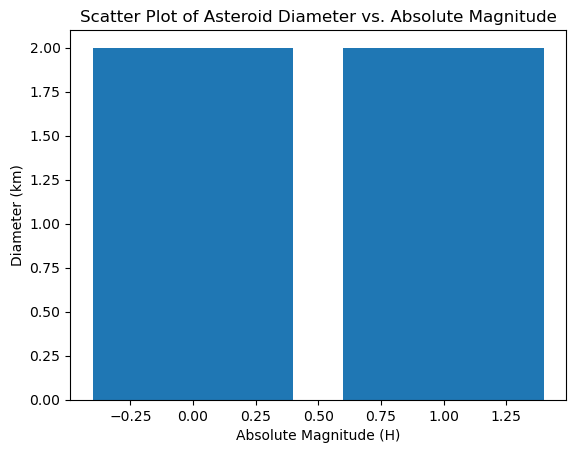

In [400]:
# assuming asteroid diameter is in column 'diameter' and absolute magnitude is in column 'H'
plt.bar(asteroid_data['pha'], asteroid_data['class'])
plt.xlabel('Absolute Magnitude (H)')
plt.ylabel('Diameter (km)')
plt.title('Scatter Plot of Asteroid Diameter vs. Absolute Magnitude')
plt.show()

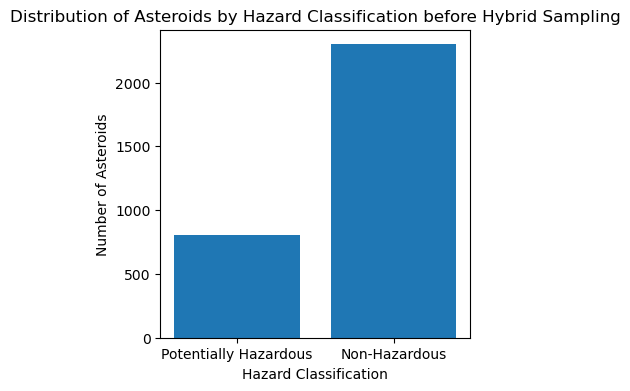

In [346]:
plt.figure(figsize=(4, 4))

hazardous_count = sum(asteroid_data['pha'] == 1)
non_hazardous_count = sum(asteroid_data['pha'] == 0)

plt.bar(['Potentially Hazardous', 'Non-Hazardous'], [hazardous_count, non_hazardous_count])
plt.title('Distribution of Asteroids by Hazard Classification before Hybrid Sampling')
plt.xlabel('Hazard Classification')
plt.ylabel('Number of Asteroids')
plt.show()

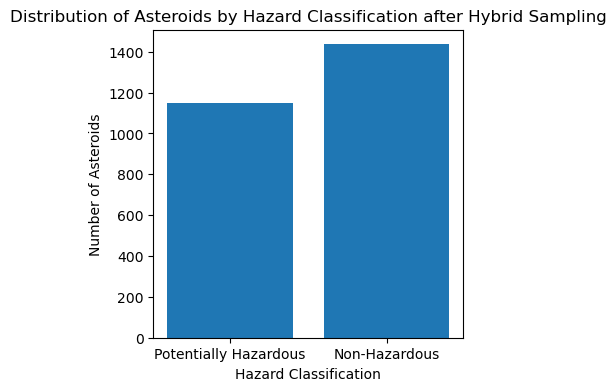

In [347]:
plt.figure(figsize=(4, 4))

hazardous_count = sum(asteroid_data_hs['pha'] == 1)
non_hazardous_count = sum(asteroid_data_hs['pha'] == 0)

plt.bar(['Potentially Hazardous', 'Non-Hazardous'], [hazardous_count, non_hazardous_count])
plt.title('Distribution of Asteroids by Hazard Classification after Hybrid Sampling')
plt.xlabel('Hazard Classification')
plt.ylabel('Number of Asteroids')
plt.show()

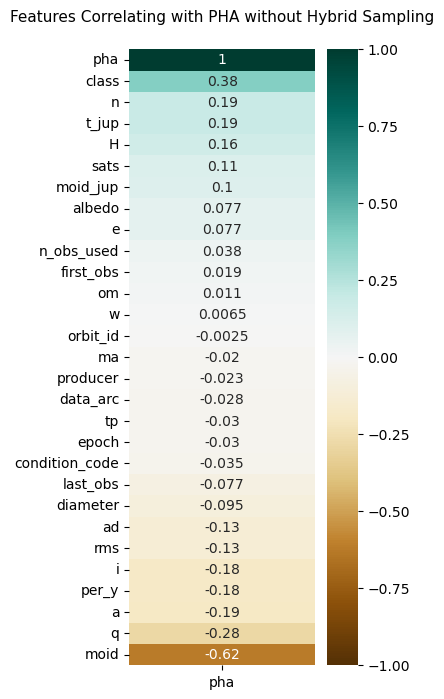

In [392]:
plt.figure(figsize=(3, 8))

heatmap = sb.heatmap(asteroid_data.corr()[['pha']].sort_values(by='pha', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with PHA without Hybrid Sampling', fontdict={'fontsize':11}, pad=20);

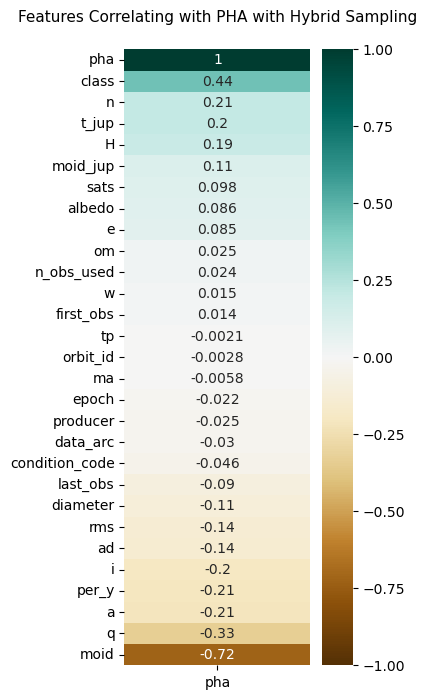

In [393]:
plt.figure(figsize=(3, 8))

heatmap = sb.heatmap(asteroid_data_hs.corr()[['pha']].sort_values(by='pha', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with PHA with Hybrid Sampling', fontdict={'fontsize':11}, pad=20);

In [352]:
X = asteroid_data[['moid','class', 'q', 'n', 't_jup', 'a', 'per_y', 'i', 'H', 'rms', 'ad', 'sats', 'moid_jup', 'diameter', 'albedo', 'e', 'last_obs', 'n_obs_used', 'condition_code', 'epoch', 'tp', 'data_arc', 'producer', 'ma', 'first_obs', 'om', 'w', 'orbit_id']]
y = asteroid_data['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
lr_scores = cross_val_score(lr, X, y, cv=5)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
rf_scores = cross_val_score(rf, X, y, cv=5)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
dt_scores = cross_val_score(dt, X, y, cv=5)

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_preds = bnb.predict(X_test)
bnb_acc = accuracy_score(y_test, bnb_preds)
bnb_scores = cross_val_score(bnb, X, y, cv=5)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_preds = mnb.predict(X_test)
mnb_acc = accuracy_score(y_test, mnb_preds)
mnb_scores = cross_val_score(mnb, X, y, cv=5)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)
gnb_acc = accuracy_score(y_test, gnb_preds)
gnb_scores = cross_val_score(gnb, X, y, cv=5)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
knn_scores = cross_val_score(knn, X, y, cv=5)

svm = SVC()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
svm_scores = cross_val_score(svm, X, y, cv=5)

In [353]:
print('\033[1m' + 'Accuracy Scores before Hybrid Sampling' + '\033[0m')

print("\nAccuracy Score for Logistic Regression, LR: ", lr_acc)
print("Accuracy Score for Random Forest, RF: ", rf_acc)
print("Accuracy Score for Decision Trees, DT: ", dt_acc)
print("Accuracy Score for BernoulliNB, BNB: ", bnb_acc)
print("Accuracy Score for MultinomialNB, MNB: ", mnb_acc)
print("Accuracy Score for GaussianNB, GNB: ", gnb_acc)
print("Accuracy Score for K-Nearest Neighbour, KNN: ", knn_acc)
print("Accuracy Score for Support Vectore Machine, SVM: ", svm_acc)

print('\033[1m' + '\nCross Validation Scores before Hybrid Sampling' + '\033[0m')

print(f'\nCross Validation Score for LR: {lr_scores.mean():.4f} (± {lr_scores.std():.4f})')
print(f'Cross Validation Score for RF: {rf_scores.mean():.4f} (± {rf_scores.std():.4f})')
print(f'Cross Validation Score for DT: {dt_scores.mean():.4f} (± {dt_scores.std():.4f})')
print(f'Cross Validation Score for BNB: {bnb_scores.mean():.4f} (± {bnb_scores.std():.4f})')
print(f'Cross Validation Score for MNB: {mnb_scores.mean():.4f} (± {mnb_scores.std():.4f})')
print(f'Cross Validation Score for GNB: {gnb_scores.mean():.4f} (± {gnb_scores.std():.4f})')
print(f'Cross Validation Score for KNN: {knn_scores.mean():.4f} (± {knn_scores.std():.4f})')
print(f'Cross Validation Score for SVM: {svm_scores.mean():.4f} (± {svm_scores.std():.4f})')

Accuracy Scores before Hybrid Sampling

Accuracy Score for Logistic Regression, LR:  0.7443609022556391
Accuracy Score for Random Forest, RF:  0.9957035445757251
Accuracy Score for Decision Trees, DT:  0.9978517722878625
Accuracy Score for BernoulliNB, BNB:  0.7497314715359829
Accuracy Score for MultinomialNB, MNB:  0.5284640171858217
Accuracy Score for GaussianNB, GNB:  0.757250268528464
Accuracy Score for K-Nearest Neighbour, KNN:  0.7261009667024705
Accuracy Score for Support Vectore Machine, SVM:  0.7432867883995704

Cross Validation Scores before Hybrid Sampling

Cross Validation Score for LR: 0.7389 (± 0.0047)
Cross Validation Score for RF: 0.9981 (± 0.0016)
Cross Validation Score for DT: 0.9974 (± 0.0024)
Cross Validation Score for BNB: 0.7466 (± 0.0056)
Cross Validation Score for MNB: 0.4841 (± 0.1333)
Cross Validation Score for GNB: 0.7527 (± 0.0053)
Cross Validation Score for KNN: 0.7305 (± 0.0033)
Cross Validation Score for SVM: 0.7411 (± 0.0007)


In [354]:
X_hs = asteroid_data_hs[['moid','class', 'q', 'n', 't_jup', 'a', 'per_y', 'i', 'H', 'rms', 'ad', 'sats', 'moid_jup', 'diameter', 'albedo', 'e', 'last_obs', 'n_obs_used', 'condition_code', 'epoch', 'tp', 'data_arc', 'producer', 'ma', 'first_obs', 'om', 'w', 'orbit_id']]
y_hs = asteroid_data_hs['pha']

X_hs_train, X_hs_test, y_hs_train, y_hs_test = train_test_split(X_hs, y_hs, test_size=0.3, random_state=42)

lr_hs = LogisticRegression()
lr_hs.fit(X_hs_train, y_hs_train)
lr_hs_preds = lr_hs.predict(X_hs_test)
lr_hs_acc = accuracy_score(y_hs_test, lr_hs_preds)
lr_hs_scores = cross_val_score(lr_hs, X_hs, y_hs, cv=5)

rf_hs = RandomForestClassifier()
rf_hs.fit(X_hs_train, y_hs_train)
rf_hs_preds = rf_hs.predict(X_hs_test)
rf_hs_acc = accuracy_score(y_hs_test, rf_hs_preds)
rf_hs_scores = cross_val_score(rf_hs, X_hs, y_hs, cv=5)

dt_hs = DecisionTreeClassifier()
dt_hs.fit(X_hs_train, y_hs_train)
dt_hs_preds = dt_hs.predict(X_hs_test)
dt_hs_acc = accuracy_score(y_hs_test, dt_hs_preds)
dt_hs_scores = cross_val_score(dt_hs, X_hs, y_hs, cv=5)

bnb_hs = BernoulliNB()
bnb_hs.fit(X_hs_train, y_hs_train)
bnb_hs_preds = bnb_hs.predict(X_hs_test)
bnb_hs_acc = accuracy_score(y_hs_test, bnb_hs_preds)
bnb_hs_scores = cross_val_score(bnb_hs, X_hs,  y_hs, cv=5)

gnb_hs = GaussianNB()
gnb_hs.fit(X_hs_train, y_hs_train)
gnb_hs_preds = gnb_hs.predict(X_hs_test)
gnb_hs_acc = accuracy_score(y_hs_test, gnb_hs_preds)
gnb_hs_scores = cross_val_score(gnb_hs, X_hs, y_hs, cv=5)

knn_hs = KNeighborsClassifier(n_neighbors=10)
knn_hs.fit(X_hs_train, y_hs_train)
knn_hs_preds = knn_hs.predict(X_hs_test)
knn_hs_acc = accuracy_score(y_hs_test, knn_hs_preds)
knn_hs_scores = cross_val_score(knn_hs, X_hs, y_hs, cv=5)

svm_hs = SVC()
svm_hs.fit(X_hs_train, y_hs_train)
svm_hs_preds = svm_hs.predict(X_hs_test)
svm_hs_acc = accuracy_score(y_hs_test, svm_hs_preds)
svm_hs_scores = cross_val_score(svm_hs, X_hs, y_hs, cv=5)

In [355]:
print('\033[1m' + 'Accuracy Scores after Hybrid Sampling' + '\033[0m')

print("\nAccuracy Score for Logistic Regression, LR: ", lr_hs_acc)
print("Accuracy Score for Random Forest, RF: ", rf_hs_acc)
print("Accuracy Score for Decision Trees, DT: ", dt_hs_acc)
print("Accuracy Score for BernoulliNB, BNB: ", bnb_hs_acc)
print("Accuracy Score for GaussianNB, GNB: ", gnb_hs_acc)
print("Accuracy Score for K-Nearest Neighbour, KNN: ", knn_hs_acc)
print("Accuracy Score for Support Vectore Machine, SVM: ", svm_hs_acc)

print('\033[1m' + '\nCross Validation Scores after Hybrid Sampling' + '\033[0m')

print(f'\nCross Validation Score for LR: {lr_hs_scores.mean():.4f} (± {lr_hs_scores.std():.4f})')
print(f'Cross Validation Score for RF: {rf_hs_scores.mean():.4f} (± {rf_hs_scores.std():.4f})')
print(f'Cross Validation Score for DT: {dt_hs_scores.mean():.4f} (± {dt_hs_scores.std():.4f})')
print(f'Cross Validation Score for BNB: {bnb_hs_scores.mean():.4f} (± {bnb_hs_scores.std():.4f})')
print(f'Cross Validation Score for GNB: {gnb_hs_scores.mean():.4f} (± {gnb_hs_scores.std():.4f})')
print(f'Cross Validation Score for KNN: {knn_hs_scores.mean():.4f} (± {knn_hs_scores.std():.4f})')
print(f'Cross Validation Score for SVM: {svm_hs_scores.mean():.4f} (± {svm_hs_scores.std():.4f})')

Accuracy Scores after Hybrid Sampling

Accuracy Score for Logistic Regression, LR:  0.538659793814433
Accuracy Score for Random Forest, RF:  0.9974226804123711
Accuracy Score for Decision Trees, DT:  0.9987113402061856
Accuracy Score for BernoulliNB, BNB:  0.7242268041237113
Accuracy Score for GaussianNB, GNB:  0.586340206185567
Accuracy Score for K-Nearest Neighbour, KNN:  0.5618556701030928
Accuracy Score for Support Vectore Machine, SVM:  0.5476804123711341

Cross Validation Scores after Hybrid Sampling

Cross Validation Score for LR: 0.5439 (± 0.0137)
Cross Validation Score for RF: 0.9985 (± 0.0014)
Cross Validation Score for DT: 0.9985 (± 0.0014)
Cross Validation Score for BNB: 0.7191 (± 0.0201)
Cross Validation Score for GNB: 0.6066 (± 0.0411)
Cross Validation Score for KNN: 0.5505 (± 0.0420)
Cross Validation Score for SVM: 0.5555 (± 0.0008)


### Classifcation Reports & Confusion Matrix

In [356]:
print('\033[1m' + 'Confusion Matrix & Classification Report' + '\033[0m')

print("\nConfusion Matrix for Logistic Regression: ", confusion_matrix(y_test, lr_preds).ravel(), "\n", classification_report(y_test, lr_preds))
print("\nConfusion Matrix for Bernoulli NB: ", confusion_matrix(y_test, bnb_preds).ravel(), "\n", classification_report(y_test, bnb_preds))
print("\nConfusion Matrix for Gaussian NB: ", confusion_matrix(y_test, gnb_preds).ravel(), "\n", classification_report(y_test, gnb_preds))
print("\nConfusion Matrix for KNN: ", confusion_matrix(y_test, knn_preds).ravel(), "\n", classification_report(y_test, knn_preds))
print("\nConfusion Matrix for SVM: ", confusion_matrix(y_test, svm_preds).ravel(), "\n", classification_report(y_test, svm_preds))

Confusion Matrix & Classification Report

Confusion Matrix for Logistic Regression:  [691   1 237   2] 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       692
           1       0.67      0.01      0.02       239

    accuracy                           0.74       931
   macro avg       0.71      0.50      0.43       931
weighted avg       0.72      0.74      0.64       931


Confusion Matrix for Bernoulli NB:  [689   3 230   9] 
               precision    recall  f1-score   support

           0       0.75      1.00      0.86       692
           1       0.75      0.04      0.07       239

    accuracy                           0.75       931
   macro avg       0.75      0.52      0.46       931
weighted avg       0.75      0.75      0.65       931


Confusion Matrix for Gaussian NB:  [688   4 222  17] 
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       692
           1       

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [362]:
#All Features
X = X[['moid','class', 'q', 'n', 't_jup', 'a', 'per_y', 'i', 'H', 'rms', 'ad', 'sats', 'moid_jup', 'diameter', 'albedo', 'e', 'last_obs', 'n_obs_used', 'condition_code', 'epoch', 'tp', 'data_arc', 'producer', 'ma', 'first_obs', 'om', 'w', 'orbit_id']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Top 20 Features
X_top20 = X[['moid','class', 'q', 'n', 't_jup', 'a', 'per_y', 'i', 'H', 'rms', 'ad', 'sats', 'moid_jup', 'diameter', 'albedo', 'e', 'last_obs', 'n_obs_used', 'condition_code', 'epoch']]
X_top20_train, X_top20_test, y_train, y_test = train_test_split(X_top20, y, test_size=0.3, random_state=42)


#Top 15 Features
X_top15 = X[['moid','class', 'q', 'n', 't_jup', 'a', 'per_y', 'i', 'H', 'rms', 'ad', 'sats', 'moid_jup', 'diameter', 'albedo']]
X_top15_train, X_top15_test, y_train, y_test = train_test_split(X_top15, y, test_size=0.3, random_state=42)


#Top 10 Features
X_top10 = X[['moid','class', 'q', 'n', 't_jup', 'a', 'per_y', 'i', 'H', 'rms']]
X_top10_train, X_top10_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.3, random_state=42)

#Top 5 Features
X_top5 = X[['moid','class', 'q', 'n', 't_jup']]
X_top5_train, X_top5_test, y_train, y_test = train_test_split(X_top5, y, test_size=0.3, random_state=42)

## Logistical Regression

In [371]:
lr = LogisticRegression(max_iter = 1000)

lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)

lr.fit(X_top20_train, y_train)
lr_top20_preds = lr.predict(X_top20_test)
lr_top20_acc = accuracy_score(y_test, lr_top20_preds)

lr.fit(X_top15_train, y_train)
lr_top15_preds = lr.predict(X_top15_test)
lr_top15_acc = accuracy_score(y_test, lr_top15_preds)

lr.fit(X_top10_train, y_train)
lr_top10_preds = lr.predict(X_top10_test)
lr_top10_acc = accuracy_score(y_test, lr_top10_preds)

lr.fit(X_top5_train, y_train)
lr_top5_preds = lr.predict(X_top5_test)
lr_top5_acc = accuracy_score(y_test, lr_top5_preds)

print('\033[1m' + 'Logistic Regression' + '\033[0m')

print('\033[1m' + '\nFor All Features' + '\033[0m')
print("Accuracy Score: ", lr_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, lr_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, lr_preds))

print('\033[1m' + '\nFor Top 20 Features' + '\033[0m')
print("Accuracy Score: ", lr_top20_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, lr_top20_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, lr_top20_preds))

print('\033[1m' + '\nFor Top 15 Features' + '\033[0m')
print("Accuracy Score: ", lr_top15_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, lr_top15_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, lr_top15_preds))

print('\033[1m' + '\nFor Top 10 Features' + '\033[0m')
print("Accuracy Score: ", lr_top10_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, lr_top10_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, lr_top10_preds))

print('\033[1m' + '\nFor Top 5 Features' + '\033[0m')
print("Accuracy Score: ", lr_top5_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, lr_top5_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, lr_top5_preds))

Logistic Regression

For All Features
Accuracy Score:  0.7443609022556391 
Confusion Matrix:  [691   1 237   2] 
Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       692
           1       0.67      0.01      0.02       239

    accuracy                           0.74       931
   macro avg       0.71      0.50      0.43       931
weighted avg       0.72      0.74      0.64       931


For Top 20 Features
Accuracy Score:  0.7422126745435016 
Confusion Matrix:  [691   1 239   0] 
Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       692
           1       0.00      0.00      0.00       239

    accuracy                           0.74       931
   macro avg       0.37      0.50      0.43       931
weighted avg       0.55      0.74      0.63       931


For Top 15 Features
Accuracy Score:  0.9377013963480129 
Confusion Matrix:  [673  19  39

## Naive Bayes (Bernoulli)

In [368]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_preds = bnb.predict(X_test)
bnb_acc = accuracy_score(y_test, bnb_preds)
bnb_scores = cross_val_score(bnb, X, y, cv=5)

bnb_top20 = BernoulliNB()
bnb_top20.fit(X_top20_train, y_train)
bnb_top20_preds = bnb_top20.predict(X_top20_test)
bnb_top20_acc = accuracy_score(y_test, bnb_top20_preds)
bnb_top20_scores = cross_val_score(bnb_top20, X_top20, y, cv=5)

bnb_top15 = BernoulliNB()
bnb_top15.fit(X_top15_train, y_train)
bnb_top15_preds = bnb_top15.predict(X_top15_test)
bnb_top15_acc = accuracy_score(y_test, bnb_top15_preds)
bnb_top15_scores = cross_val_score(bnb_top15, X_top15, y, cv=5)

bnb_top10 = BernoulliNB()
bnb_top10.fit(X_top10_train, y_train)
bnb_top10_preds = bnb_top10.predict(X_top10_test)
bnb_top10_acc = accuracy_score(y_test, bnb_top10_preds)
bnb_top10_scores = cross_val_score(bnb_top10, X_top10, y, cv=5)

bnb_top5 = BernoulliNB()
bnb_top5.fit(X_top5_train, y_train)
bnb_top5_preds = bnb_top5.predict(X_top5_test)
bnb_top5_acc = accuracy_score(y_test, bnb_top5_preds)
bnb_top5_scores = cross_val_score(bnb_top5, X_top5, y, cv=5)

print('\033[1m' + 'BernoulliNB Accuracy Scores' + '\033[0m')

print('\033[1m' + '\nFor All Features' + '\033[0m')
print("Accuracy Score: ", bnb_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, bnb_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, bnb_preds))

print('\033[1m' + '\nFor Top 20 Features' + '\033[0m')
print("Accuracy Score: ", bnb_top20_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, bnb_top20_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, bnb_top20_preds))

print('\033[1m' + '\nFor Top 15 Features' + '\033[0m')
print("Accuracy Score: ", bnb_top15_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, bnb_top15_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, bnb_top15_preds))

print('\033[1m' + '\nFor Top 10 Features' + '\033[0m')
print("Accuracy Score: ", bnb_top10_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, bnb_top10_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, bnb_top10_preds))

print('\033[1m' + '\nFor Top 5 Features' + '\033[0m')
print("Accuracy Score: ", bnb_top5_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, bnb_top5_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, bnb_top5_preds))

BernoulliNB Accuracy Scores

For All Features
Accuracy Score:  0.7497314715359829 
Confusion Matrix:  [689   3 230   9] 
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86       692
           1       0.75      0.04      0.07       239

    accuracy                           0.75       931
   macro avg       0.75      0.52      0.46       931
weighted avg       0.75      0.75      0.65       931


For Top 20 Features
Accuracy Score:  0.748657357679914 
Confusion Matrix:  [689   3 231   8] 
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.85       692
           1       0.73      0.03      0.06       239

    accuracy                           0.75       931
   macro avg       0.74      0.51      0.46       931
weighted avg       0.74      0.75      0.65       931


For Top 15 Features
Accuracy Score:  0.748657357679914 
Confusion Matrix:  [689  

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

## Naive Bayes (Gaussian)

In [369]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)
gnb_acc = accuracy_score(y_test, gnb_preds)
gnb_scores = cross_val_score(gnb, X, y, cv=5)

gnb.fit(X_top20_train, y_train)
gnb_top20_preds = gnb.predict(X_top20_test)
gnb_top20_acc = accuracy_score(y_test, gnb_top20_preds)
gnb_top20_scores = cross_val_score(gnb, X_top20, y, cv=5)

gnb.fit(X_top15_train, y_train)
gnb_top15_preds = gnb.predict(X_top15_test)
gnb_top15_acc = accuracy_score(y_test, gnb_top15_preds)
gnb_top15_scores = cross_val_score(gnb, X_top15, y, cv=5)

gnb.fit(X_top10_train, y_train)
gnb_top10_preds = gnb.predict(X_top10_test)
gnb_top10_acc = accuracy_score(y_test, gnb_top10_preds)
gnb_top10_scores = cross_val_score(gnb, X_top10, y, cv=5)

gnb.fit(X_top5_train, y_train)
gnb_top5_preds = gnb.predict(X_top5_test)
gnb_top5_acc = accuracy_score(y_test, gnb_top5_preds)
gnb_top5_scores = cross_val_score(gnb, X_top5, y, cv=5)

print('\033[1m' + 'GaussianNB Accuracy Scores' + '\033[0m')

print('\033[1m' + '\nFor All Features' + '\033[0m')
print("Accuracy Score: ", gnb_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, gnb_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, gnb_preds))

print('\033[1m' + '\nFor Top 20 Features' + '\033[0m')
print("Accuracy Score: ", gnb_top20_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, gnb_top20_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, gnb_top20_preds))

print('\033[1m' + '\nFor Top 15 Features' + '\033[0m')
print("Accuracy Score: ", gnb_top15_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, gnb_top15_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, gnb_top15_preds))

print('\033[1m' + '\nFor Top 10 Features' + '\033[0m')
print("Accuracy Score: ", gnb_top10_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, gnb_top10_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, gnb_top10_preds))

print('\033[1m' + '\nFor Top 5 Features' + '\033[0m')
print("Accuracy Score: ", gnb_top5_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, gnb_top5_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, gnb_top5_preds))

GaussianNB Accuracy Scores

For All Features
Accuracy Score:  0.757250268528464 
Confusion Matrix:  [688   4 222  17] 
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       692
           1       0.81      0.07      0.13       239

    accuracy                           0.76       931
   macro avg       0.78      0.53      0.49       931
weighted avg       0.77      0.76      0.67       931


For Top 20 Features
Accuracy Score:  0.7593984962406015 
Confusion Matrix:  [687   5 219  20] 
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       692
           1       0.80      0.08      0.15       239

    accuracy                           0.76       931
   macro avg       0.78      0.54      0.51       931
weighted avg       0.77      0.76      0.68       931


For Top 15 Features
Accuracy Score:  0.916219119226638 
Confusion Matrix:  [659  3

## Support Vector Machine

In [370]:
svm = SVC()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
svm_scores = cross_val_score(svm, X, y, cv=5)

svm.fit(X_top20_train, y_train)
svm_top20_preds = svm.predict(X_top20_test)
svm_top20_acc = accuracy_score(y_test, svm_top20_preds)

svm.fit(X_top15_train, y_train)
svm_top15_preds = svm.predict(X_top15_test)
svm_top15_acc = accuracy_score(y_test, svm_top15_preds)

svm.fit(X_top10_train, y_train)
svm_top10_preds = svm.predict(X_top10_test)
svm_top10_acc = accuracy_score(y_test, svm_top10_preds)

svm.fit(X_top5_train, y_train)
svm_top5_preds = svm.predict(X_top5_test)
svm_top5_acc = accuracy_score(y_test, svm_top5_preds)

print('\033[1m' + 'SVC Accuracy Scores' + '\033[0m')

print('\033[1m' + '\nFor All Features' + '\033[0m')
print("Accuracy Score: ", svm_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, svm_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, svm_preds))

print('\033[1m' + '\nFor Top 20 Features' + '\033[0m')
print("Accuracy Score: ", svm_top20_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, svm_top20_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, svm_top20_preds))

print('\033[1m' + '\nFor Top 15 Features' + '\033[0m')
print("Accuracy Score: ", svm_top15_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, svm_top15_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, svm_top15_preds))

print('\033[1m' + '\nFor Top 10 Features' + '\033[0m')
print("Accuracy Score: ", svm_top10_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, svm_top10_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, svm_top10_preds))

print('\033[1m' + '\nFor Top 5 Features' + '\033[0m')
print("Accuracy Score: ", svm_top5_acc, "\nConfusion Matrix: ", confusion_matrix(y_test, svm_top5_preds).ravel(), "\nClassification Report:\n", classification_report(y_test, svm_top5_preds))

SVC Accuracy Scores

For All Features
Accuracy Score:  0.7432867883995704 
Confusion Matrix:  [692   0 239   0] 
Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       692
           1       0.00      0.00      0.00       239

    accuracy                           0.74       931
   macro avg       0.37      0.50      0.43       931
weighted avg       0.55      0.74      0.63       931


For Top 20 Features
Accuracy Score:  0.7432867883995704 
Confusion Matrix:  [692   0 239   0] 
Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       692
           1       0.00      0.00      0.00       239

    accuracy                           0.74       931
   macro avg       0.37      0.50      0.43       931
weighted avg       0.55      0.74      0.63       931


For Top 15 Features
Accuracy Score:  0.7465091299677766 
Confusion Matrix:  [691   1 235

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metr

## ROC Curves

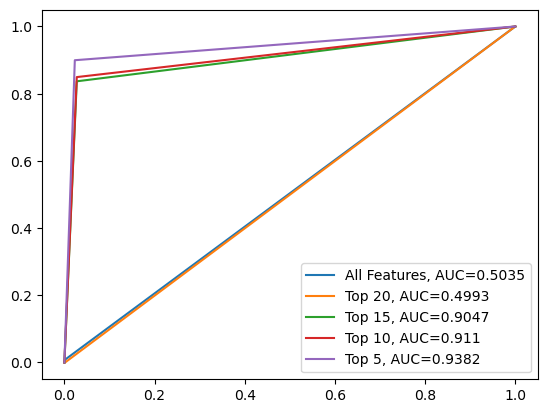

In [376]:
#Logistic Regression
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, lr_preds)
auc = round(metrics.roc_auc_score(y_test, lr_preds), 4)
plt.plot(fpr,tpr,label="All Features, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, lr_top20_preds)
auc = round(metrics.roc_auc_score(y_test, lr_top20_preds), 4)
plt.plot(fpr,tpr,label="Top 20, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, lr_top15_preds)
auc = round(metrics.roc_auc_score(y_test, lr_top15_preds), 4)
plt.plot(fpr,tpr,label="Top 15, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, lr_top10_preds)
auc = round(metrics.roc_auc_score(y_test, lr_top10_preds), 4)
plt.plot(fpr,tpr,label="Top 10, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, lr_top5_preds)
auc = round(metrics.roc_auc_score(y_test, lr_top5_preds), 4)
plt.plot(fpr,tpr,label="Top 5, AUC="+str(auc))

plt.legend()

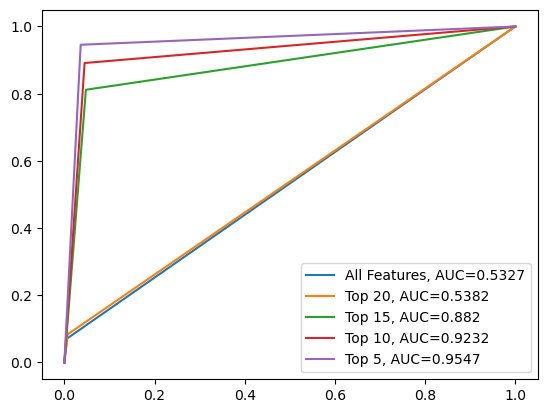

In [378]:
#Suport Vector Machines
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, gnb_preds)
auc = round(metrics.roc_auc_score(y_test, gnb_preds), 4)
plt.plot(fpr,tpr,label="All Features, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, gnb_top20_preds)
auc = round(metrics.roc_auc_score(y_test, gnb_top20_preds), 4)
plt.plot(fpr,tpr,label="Top 20, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, gnb_top15_preds)
auc = round(metrics.roc_auc_score(y_test, gnb_top15_preds), 4)
plt.plot(fpr,tpr,label="Top 15, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, gnb_top10_preds)
auc = round(metrics.roc_auc_score(y_test, gnb_top10_preds), 4)
plt.plot(fpr,tpr,label="Top 10, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, gnb_top5_preds)
auc = round(metrics.roc_auc_score(y_test, gnb_top5_preds), 4)
plt.plot(fpr,tpr,label="Top 5, AUC="+str(auc))

plt.legend()